In [1]:
import os
import sys
from pathlib import Path
from torch.nn import DataParallel
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches

pv_vision_dir = os.path.join(Path.home(), 'pv-vision')
functions_dir = os.path.join(Path.home(), 'ecc-cracks')

sys.path.append(pv_vision_dir)
sys.path.append(functions_dir)

ojas_functions_dir = os.path.join(Path.home(), 'pvcracks/retrain/')
sys.path.append(ojas_functions_dir)

import functions
from tutorials.unet_model import construct_unet

In [3]:
# https://stackoverflow.com/questions/61909973/pytorch-load-incompatiblekeys

In [2]:
def load_dataset(root):
    transformers = functions.Compose([functions.FixResize(256), functions.ToTensor(), functions.Normalize()])
    
    train_dataset = functions.SolarDataset(root, image_folder="img/train", 
        mask_folder="ann/train", transforms=transformers)
    
    val_dataset = functions.SolarDataset(root, image_folder="img/val", 
            mask_folder="ann/val", transforms=transformers)

    return train_dataset, val_dataset

In [3]:
def load_device_and_model(weight_path):
    device = torch.device("mps")
    unet = construct_unet(5)
    unet = torch.nn.DataParallel(unet)
    
    checkpoint = torch.load(weight_path, map_location=device)
    from collections import OrderedDict

    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = "module." + k
        new_state_dict[name] = v
    # for k, v in checkpoint.items():
    #     new_state_dict[k] = v
    
    unet.load_state_dict(new_state_dict)

    model = unet.module.to(device)
    
    return device, model

In [4]:
def show(mask, raw_img, test_res, layers_to_render=None):
    mask_cpu = mask.cpu().numpy()
    # mask_cpu = mask.cpu()
    # mask_cpu = functions.realign_mask(mask_cpu)

    cmap = mpl.colormaps["viridis"].resampled(5)  # define the colormap
    cmaplist = [cmap(i) for i in range(5)]

    fig, ax = plt.subplots(ncols=3, figsize=(12, 12), layout='compressed')
    # fig, ax = plt.subplots(ncols=2, figsize=(12,6), layout='compressed')

    im = ax[0].imshow(raw_img.convert("L"), cmap="gray", interpolation="None")
    ax[0].axis("off")

    clim = (0, 4)
    im = ax[1].imshow(
        mask_cpu,
        cmap="viridis",
        clim=clim,
    )
    ax[1].axis("off")
    ax[1].set_title("Ground Truth Mask")

    if layers_to_render is not None:
        test_res = np.where(np.isin(test_res, layers_to_render), test_res, 0)

    ax[2].imshow(test_res, cmap="viridis", clim=clim, interpolation="None")
    handles, labels = ax[2].get_legend_handles_labels()

    for c, classlabel in zip(
        cmaplist, [f"({k}) {v}" for k, v in category_mapping.items()]
    ):
        patch = mpatches.Patch(color=c, label=classlabel, ec="k")
        handles.append(patch)
    ax[2].legend(handles=handles, fontsize="x-small")
    ax[2].axis("off")
    ax[2].set_title("Retrained Model Prediction")

In [5]:
def inference_and_show(idx, root, weight_path, layers_to_render=None):
    train_dataset, val_dataset = load_dataset(root)
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    
    device, model = load_device_and_model(weight_path)

    # img, mask = train_loader.dataset.__getitem__(idx)
    # raw_img, _ = train_loader.dataset.__getraw__(idx)
    
    img, mask = val_loader.dataset.__getitem__(idx)
    raw_img, _ = val_loader.dataset.__getraw__(idx)
    
    img = img.to(device)
    test_res = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
    test_res = np.argmax(test_res, axis=0)

    show(mask, raw_img, test_res, layers_to_render=layers_to_render)

In [6]:

category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell"}
# root = Path("/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_LBNL_ASU/") 
# weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_LBNL_ASU/checkpoints/Combined_CWRU_LBNL_ASU3/epoch_30/Combined_CWRU_LBNL_ASU.pt"
# ann_dir = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_LBNL_ASU/ann/val/"
# weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/retrained_pv-vision_model.pt"

# root = Path("/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_LBNL_ASU_No_Busbar/") 
# weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_LBNL_ASU_No_Busbar/checkpoints/Combined_CWRU_LBNL_ASU_No_Busbar1/epoch_30/Combined_CWRU_LBNL_ASU_No_Busbar.pt"
# ann_dir = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_LBNL_ASU_No_Busbar/ann/train/"

# root = Path("/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_ASU/") 
# weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_ASU/checkpoints/Combined_CWRU_ASU1/epoch_30/Combined_CWRU_ASU.pt"
# # ann_dir = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_ASU/ann/train/"
# ann_dir = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_ASU/ann/val/"

# root = Path("/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CWRU_Dupont_Mono_ContinuousCracks/") 
# ann_dir = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CWRU_Dupont_Mono_ContinuousCracks/ann/val/"
# weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CWRU_Dupont_Mono_ContinuousCracks/checkpoints/CWRU_Dupont_Mono_ContinuousCracks1/epoch_30/CWRU_Dupont_Mono_ContinuousCracks.pt"
# weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/pv-vision_model.pt"
# weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CWRU_Dupont_Mono_ContinuousCracks/checkpoints/CWRU_Dupont_Mono_ContinuousCracks2/epoch_30/CWRU_Dupont_Mono_ContinuousCracks_Fresh.pt"

# root = Path("/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_ASU_ContinuousCracks/") 
# ann_dir = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_ASU_ContinuousCracks/ann/val/"
# weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_ASU_ContinuousCracks/checkpoints/Combined_CWRU_ASU_ContinuousCracks1/epoch_30/model.pt"

root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_Combined_CWRU_LBNL_ASU/"
checkpoint_name = "Fresh_Combined_CWRU_LBNL_ASU"

# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_LBNL/"
# checkpoint_name = "Fresh_LBNL"
    
ann_dir = root + "ann/val/"
weight_path = root + "checkpoints/" + checkpoint_name + "1/epoch_30/model.pt"


device, model = load_device_and_model(weight_path)

train_dataset, val_dataset = load_dataset(root)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_94858/4234224754.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, map_loca

63


/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_94858/4234224754.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, map_loca

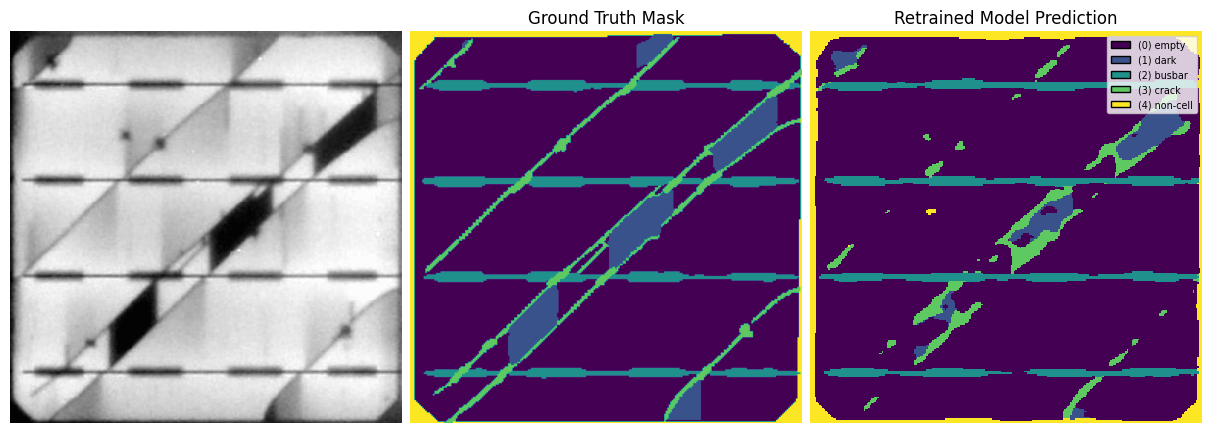

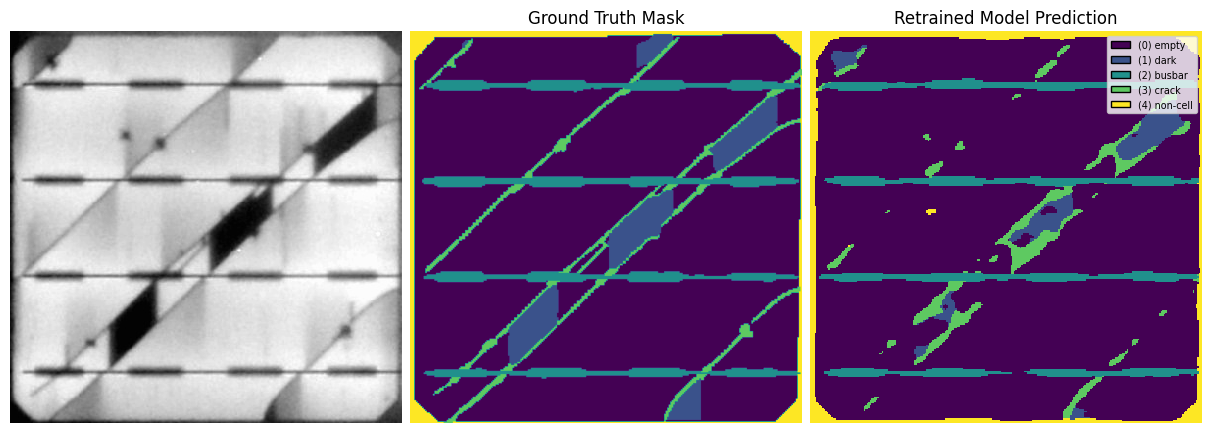

In [14]:
# cr_name = 'cr_SW1-DH3000-1500h-PT-cell50.npy'
# bu_name = 'bu_SW1-DH3000-1500h-PT-cell50.npy'

# cr_name = "cr_2_EL_18.09.2023-15-27-31_unknownID_ASU Minisample_SHJ1_91.npy"
# bu_name = 'bu_2_EL_18.09.2023-15-27-31_unknownID_ASU Minisample_SHJ1_91.npy'

bu_name = "bu_1090.npy"
cr_name = "cr_1090.npy"

cr_idx = np.ravel(np.where(val_loader.dataset.mask_list == os.path.join(ann_dir, cr_name)))[0]
bu_idx = np.ravel(np.where(val_loader.dataset.mask_list == os.path.join(ann_dir, bu_name)))[0]

print(cr_idx)

inference_and_show(cr_idx, root, weight_path)
inference_and_show(bu_idx, root, weight_path)

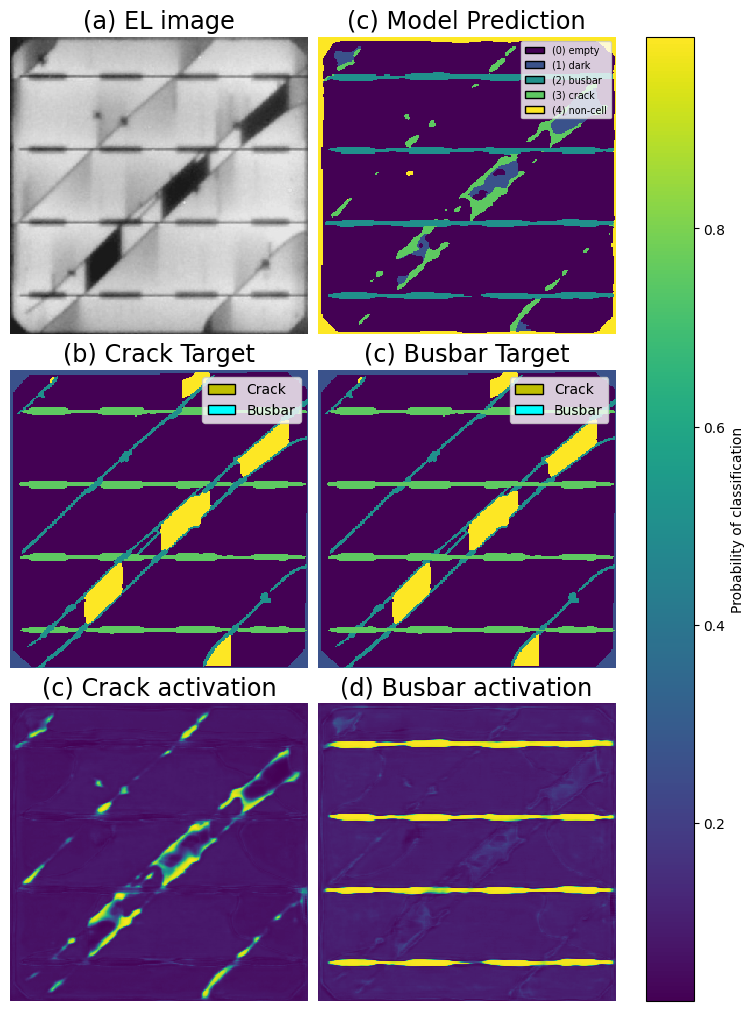

In [ ]:
clim = (0,4)

# img, cr_mask = train_loader.dataset. __getitem__(cr_idx)
# img, bu_mask = train_loader.dataset. __getitem__(bu_idx)

img, cr_mask = val_loader.dataset.__getitem__(cr_idx)
img, bu_mask = val_loader.dataset.__getitem__(bu_idx)

cr_mask = functions.realign_mask(cr_mask)
bu_mask = functions.realign_mask(bu_mask)
img = img.to(device)

sigmoid = lambda x: 1 /(1 + np.exp(-x))
test_res_chan = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
test_res_act = sigmoid(test_res_chan)

model_prediction = np.argmax(test_res_chan, axis=0)

bu_layer = test_res_act[2]
cr_layer = test_res_act[3]

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(10, 10), layout='compressed')

###
# img, _ = train_loader.dataset.__getraw__(cr_idx)
img, _ = val_loader.dataset.__getraw__(cr_idx)
ax[0, 0].imshow(img, cmap='gray', interpolation='None')
ax[0, 0].axis('off')
ax[0, 0].set_title('(a) EL image', fontsize='xx-large')
###
ax[0, 1].imshow(model_prediction, cmap='viridis', clim=clim, interpolation='none')
ax[0, 1].axis('off')
ax[0, 1].set_title('(c) Model Prediction', fontsize='xx-large')
handles, labels = ax[0, 1].get_legend_handles_labels()
cmap = mpl.colormaps['viridis'].resampled(5)  # define the colormap
cmaplist = [cmap(i) for i in range(5)]
for c, classlabel in zip(cmaplist, [f'({k}) {v}' for k, v in category_mapping.items()]):
    patch = mpatches.Patch(color=c, label=classlabel, ec='k')
    handles.append(patch)
ax[0, 1].legend(handles=handles, fontsize='x-small')
###
ax[1, 0].imshow(cr_mask, cmap='viridis', interpolation='None')
ax[1, 0].axis('off')
ax[1, 0].set_title('(b) Crack Target', fontsize='xx-large')
handles, labels = ax[1, 0].get_legend_handles_labels()
yellow_patch = mpatches.Patch(color='y', label='Crack', ec='k')
handles.append(yellow_patch)
cyan_patch = mpatches.Patch(color='cyan', label='Busbar', ec='k')
handles.append(cyan_patch)
ax[1, 0].legend(handles=handles)
###
ax[1, 1].imshow(bu_mask, cmap='viridis', interpolation='None')
ax[1, 1].axis('off')
ax[1, 1].set_title('(c) Busbar Target', fontsize='xx-large')
handles, labels = ax[1, 1].get_legend_handles_labels()
yellow_patch = mpatches.Patch(color='y', label='Crack', ec='k')
handles.append(yellow_patch)
cyan_patch = mpatches.Patch(color='cyan', label='Busbar', ec='k')
handles.append(cyan_patch)
ax[1, 1].legend(handles=handles)
###
ax[2, 0].imshow(cr_layer, cmap='viridis', interpolation='None')
ax[2, 0].axis('off')
ax[2, 0].set_title('(c) Crack activation', fontsize='xx-large')
###
im = ax[2, 1].imshow(bu_layer, cmap='viridis', interpolation='None')
ax[2, 1].axis('off')
ax[2, 1].set_title('(d) Busbar activation', fontsize='xx-large')
fig.colorbar(im, ax=ax, label='Probability of classification')

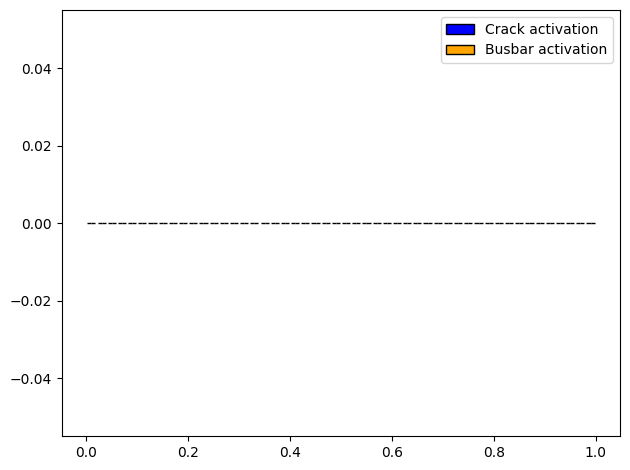

In [10]:
cr_act = cr_layer[(bu_mask.numpy() == 2) & (cr_mask.numpy() == 3)]
bu_act = bu_layer[(bu_mask.numpy() == 2) & (cr_mask.numpy() == 3)]

fig, ax = plt.subplots()

ax.hist([cr_act,  bu_act], bins=50, ec='k')

handles, labels = ax.get_legend_handles_labels()
o_patch = mpatches.Patch(color='orange', label='Busbar activation', ec='k')
b_patch = mpatches.Patch(color='b', label='Crack activation', ec='k')
handles.append(b_patch) 
handles.append(o_patch) 
ax.legend(handles=handles)
fig.tight_layout()

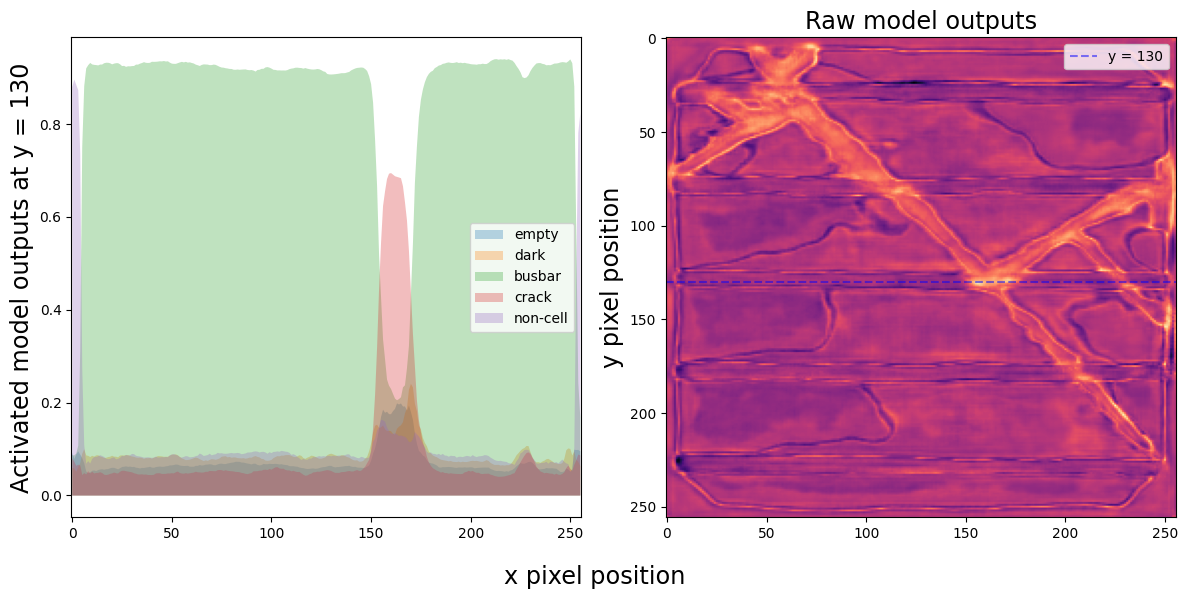

In [11]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell"}

# idx = train_idx[0]
# img, mask = train_loader.dataset.__getitem__(cr_idx)
img, mask = val_loader.dataset.__getitem__(cr_idx)
img = img.to(device)
test_res = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()#.argmax(axis = 0)
test_res = np.argmax(test_res, axis = 0)

sigmoid = lambda x: 1 /(1 + np.exp(-x))
test_res_chan = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
test_res_act = sigmoid(test_res_chan)

yslice= 130
# yslice= 180
xmax = 60
ymax = 256

sliced = test_res_act[:, yslice, :]
fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=True)

for i in range(sliced.shape[0]):
    ax[0].fill_between(np.arange(0, 256, 1), sliced[i], alpha=0.3, label=category_mapping[i])
ax[0].legend()
ax[0].set_ylabel(f'Activated model outputs at y = {yslice}', fontsize='xx-large')

ax[1].imshow(test_res_chan.sum(axis = 0), cmap  = "magma")
ax[1].set_aspect('auto')
ax[1].axhline(yslice, ls='--', c='b', alpha=0.5, label=f'y = {yslice}')
ax[1].legend()
ax[1].set_title('Raw model outputs', fontsize='xx-large')
ax[1].set_ylabel('y pixel position', fontsize='xx-large')
fig.supxlabel('x pixel position', fontsize='xx-large')
# fig.suptitle(val_loader.dataset. __getname__(cr_idx))
fig.tight_layout()

Text(0.5, 1.0, 'Activated model outputs at y = 180')

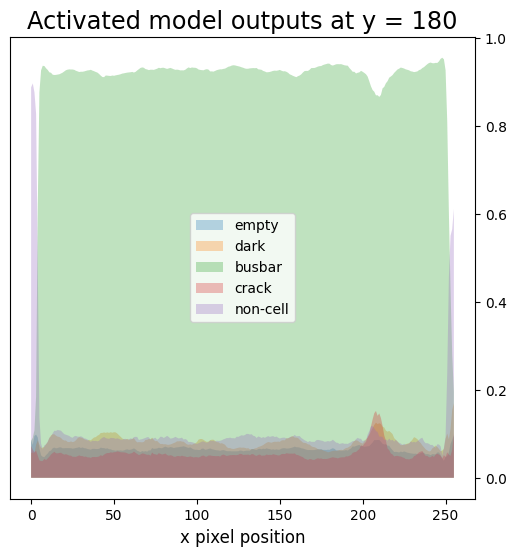

In [12]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell"}

# idx = train_idx[0]
# img, mask = train_loader.dataset. __getitem__(cr_idx)
img, mask = val_loader.dataset.__getitem__(cr_idx)
img = img.to(device)
test_res = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()#.argmax(axis = 0)
test_res = np.argmax(test_res, axis = 0)

sigmoid = lambda x: 1 /(1 + np.exp(-x))
test_res_chan = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
test_res_act = sigmoid(test_res_chan)

yslice= 160
yslice= 180
xmax = 60
ymax = 256

sliced = test_res_act[:, yslice, :]
fig, ax = plt.subplots(figsize=(6,6))

for i in range(sliced.shape[0]):
    ax.fill_between(np.arange(0, 256, 1), sliced[i], alpha=0.3, label=category_mapping[i])
ax.legend()
ax.yaxis.tick_right()
ax.set_xlabel('x pixel position', fontsize='large')
ax.set_title(f'Activated model outputs at y = {yslice}', fontsize='xx-large')

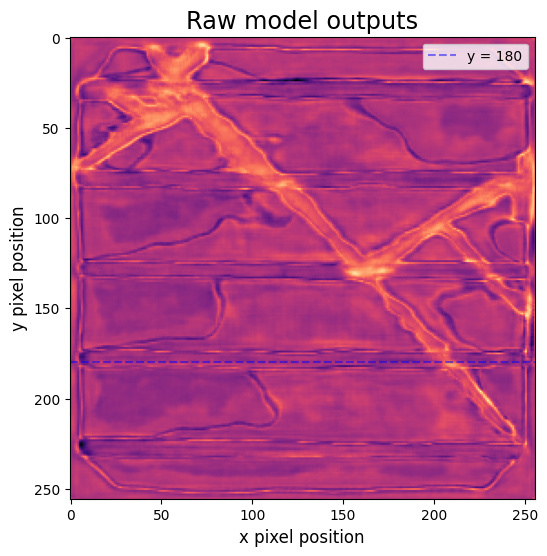

In [13]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(test_res_chan.sum(axis = 0), cmap  = "magma")
ax.axhline(yslice, ls='--', c='b', alpha=0.5, label=f'y = {yslice}')
ax.legend()
ax.set_title('Raw model outputs', fontsize='xx-large')
ax.set_ylabel('y pixel position', fontsize='large')
ax.set_xlabel('x pixel position', fontsize='large')
ax.set_aspect('auto')